# Temporal Fluctuations

Neural oscillations are temporally variable.

### Issue

Neural oscillations are often variable through time (bursty). 

This can exhibit can exhibit as power differences, if temporal variability is not considered and addressed.

### Solution

If and when oscillations are or may be bursty, burst detection can be used to identify times in which the oscillation is present. 

This can be used to restrict analyses to segments in which the oscillation is present, upon which measures of interest can be computed. 

### Related Work

The following papers include discussion of this topic:
- [The rate of transient beta frequency events predicts behavior across tasks and species](https://doi.org/10.7554/eLife.29086.001), Shin et al, 2017
- [Dissecting Transient Burst Events](https://doi.org/10.1016/j.tics.2020.07.004), Zich et al, 2020

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

from fooof.plts.spectra import plot_spectra_shading
from fooof.utils import trim_spectrum

from neurodsp.sim import sim_combined, sim_powerlaw, sim_bursty_oscillation
from neurodsp.spectral import compute_spectrum
from neurodsp.timefrequency import amp_by_time
from neurodsp.burst import detect_bursts_dual_threshold
from neurodsp.utils import create_times, set_random_seed
from neurodsp.plts.time_series import plot_time_series, plot_bursts

## Functions

In [2]:
def _set_lr_spines(ax, lw=None):
    """Set the spines to drop top & right box & set linewidth."""

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    if lw:
        ax.spines['left'].set_linewidth(lw)
        ax.spines['bottom'].set_linewidth(lw)
        
def plot_bar(d1, d2, labels=None, err=None, **plt_kwargs):
    """   """
    
    _, ax = plt.subplots()
    
    if err:
        err = [np.nanstd(d1), np.nanstd(d2)]
    
    ax.bar([0.5, 1.5], [avg_func(d1), avg_func(d2)], yerr=err,
           tick_label=labels, **plt_kwargs)

    ax.set_xlim([0, 2])
    
    ax.set_yticks([]);
    if not labels: ax.set_xticks([]);
    
    _set_lr_spines(ax, 4)

## Settings

In [3]:
import seaborn as sns
sns.set_context('poster')

In [4]:
# Set random seed
set_random_seed(808)

In [5]:
# Define general simulation settings
n_seconds = 100
fs = 1000

times = create_times(n_seconds, fs)

In [6]:
# Set the function for averaging
avg_func = np.nanmean

In [7]:
# Define parameters for the simulations
cf = 10
exp = -1.5
ap_filt = (1.5, 50)

enter1 = 0.2
leave1 = 0.4

enter2 = 0.4
leave2 = 0.2

In [8]:
# # Collect parameters and set up simulations
# comps1 = {'sim_powerlaw' : {'exponent' : exp, 'f_range' : ap_filt},
#           'sim_bursty_oscillation' : {'freq' : cf, 'enter_burst' : enter1, 'leave_burst' : leave1}}
# comps2 = {'sim_powerlaw' : {'exponent' : exp, 'f_range' : ap_filt},
#           'sim_bursty_oscillation' : {'freq' : cf, 'enter_burst' : enter2, 'leave_burst' : leave2}}

# # Define relative power of the signal components
# comp_vars = [1., 0.75]

In [9]:
# //
nperseg = 1*fs

In [10]:
# Define frequency ranges of interest
alpha_range = (8, 12)
psd_range = [2, 40]

In [11]:
# Define some plot settings
plt_kwargs = {'xlabel' : '', 'ylabel' : ''}
labels = ['low-burst', 'high-burst']

leg_size = 22

In [12]:
alpha_color = '#1882d9'

In [13]:
c1 = '#0000ff'
c2 = '#00693a'

colors = [c1, c2]

bcol = '#eb0000'

In [14]:
SAVE_FIG = False

### Simulate Time Series

For this comparison, we will simulate and compare two example signals. 

Each time series will contain a bursty alpha oscillation, but the two signals will vary in their burst probability.

In [15]:
#
ap = sim_powerlaw(n_seconds, fs, exp, f_range=ap_filt, variance=0.75)

#
burst1 = sim_bursty_oscillation(n_seconds, fs, cf, 'prob', variance=1.,
                                burst_params={'enter_burst' : enter1, 'leave_burst' : leave1})
burst2 = sim_bursty_oscillation(n_seconds, fs, cf, 'prob', variance=1., 
                                burst_params={'enter_burst' : enter2, 'leave_burst' : leave2})

In [16]:
# 
sig1 = ap + burst1
sig2 = ap + burst2

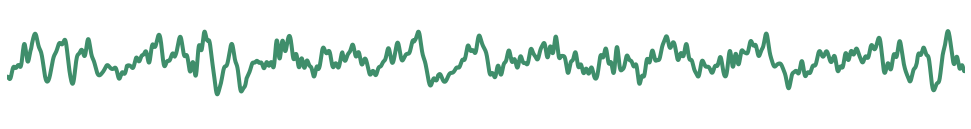

In [17]:
# Plot the first signal: high burst probability
plot_time_series(times, sig1, xlim=[1, 5], alpha=0.75, colors=c2, lw=4)
plt.axis('off')
if SAVE_FIG: plt.savefig('figures/04-burst_high.pdf', bbox_inches='tight')

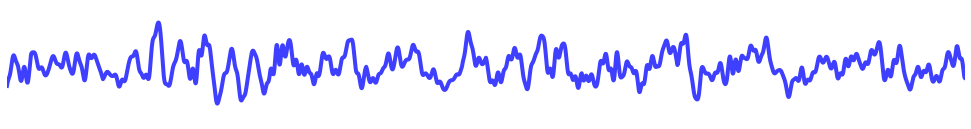

In [18]:
# Plot the first signal: low burst probability
plot_time_series(times, sig2, xlim=[1, 5], alpha=0.75, colors=c1, lw=4)
plt.axis('off')
if SAVE_FIG: plt.savefig('figures/04-burst_low.pdf', bbox_inches='tight')

### Compare the Power Spectra

Next, let's compare the power spectra of the two example signals.

In [19]:
# Compute power spectra of each signal
freqs1, powers1 = trim_spectrum(*compute_spectrum(sig1, fs, nperseg=nperseg), psd_range)
freqs2, powers2 = trim_spectrum(*compute_spectrum(sig2, fs, nperseg=nperseg), psd_range)

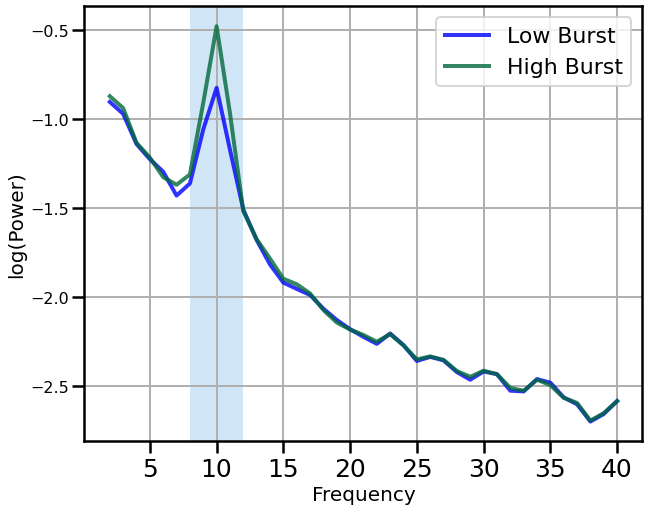

In [20]:
# Plot the power spectra, comparing between signals
plot_spectra_shading(freqs1, [powers1, powers2], alpha_range,
                     labels=['Low Burst', 'High Burst'],
                     log_freqs=False, log_powers=True,
                     lw=4, shade_colors=alpha_color)
ax = plt.gca()
for line, color in zip(ax.get_lines(), colors):
    line.set_color(color)
    line.set_alpha(0.8)    
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
plt.legend(prop={'size': leg_size})
if SAVE_FIG: plt.savefig('figures/04-burst_psd.pdf', bbox_inches='tight')

Based simply on the power spectra, it looks like our two signals have a clear difference in alpha power. 

### Apply Burst Detection

By construction, we know our simulated signals have temporal variability in their oscillations. 

To dig into this, let's apply burst detection to try and measure when, in time, the oscillations are present. 

Note: here we are using burst detection using the 
[dual-amplitude](https://neurodsp-tools.github.io/neurodsp/auto_tutorials/burst/plot_BurstDetection.html)
algorithm.

In [21]:
# Apply burst detection to the first signal (low burst probability)
bursting1 = detect_bursts_dual_threshold(sig1, fs, (0.8, 1.), alpha_range)

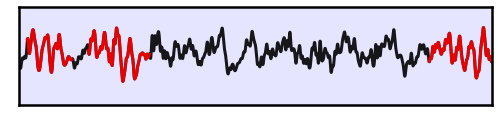

In [22]:
# Plot a segment of burst detection on the first signal
_, ax = plt.subplots(figsize=(8, 2.5))
plot_bursts(times, sig1, bursting1, xlim=[1, 5], **plt_kwargs, alpha=[0.9, 0.9], ax=ax)
plt.xticks([]); plt.yticks([]);
ax.axvspan(1, 5, color=c1, alpha=0.1, lw=0)
if SAVE_FIG: plt.savefig('figures/04-burst_det1.pdf', bbox_inches='tight')

In [23]:
# Apply burst detection to the first signal (high burst probability)
bursting2 = detect_bursts_dual_threshold(sig2, fs, (0.4, 1), alpha_range)

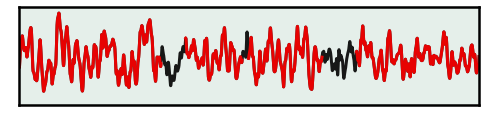

In [24]:
# Plot a segment of burst detection on the first signal
xlim = [5, 10]
_, ax = plt.subplots(figsize=(8, 2.5))
plot_bursts(times, sig2, bursting2, xlim=xlim, **plt_kwargs, alpha=[0.9, 0.9], ax=ax)
plt.xticks([]); plt.yticks([]);
ax.axvspan(*xlim, color=c2, alpha=0.1, lw=0)
if SAVE_FIG: plt.savefig('figures/04-burst_det2.pdf', bbox_inches='tight')

In the above we can see, as expected the two signals differ in the prominence of the bursting.

### Compare Oscillatory Power

Now that we have identified the bursts, we can compare the power of the oscillation across the whole signal, to the power of the oscillations during moments of bursting. 

In [25]:
# Calculate instantaneous amplitude of each signal
amp1 = amp_by_time(sig1, fs, alpha_range)
amp2 = amp_by_time(sig2, fs, alpha_range)

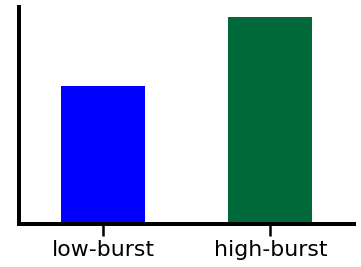

In [26]:
# Plot the comparison of total power between signals
plot_bar(amp1, amp2, labels, color=colors, width=0.5)
if SAVE_FIG: plt.savefig('figures/04-bar_oscpow.pdf', bbox_inches='tight')

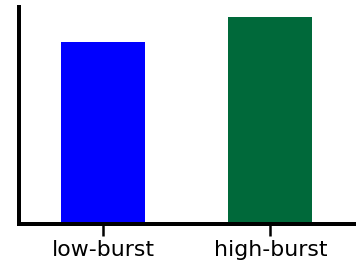

In [27]:
# Plot the comparison of burst power between signals
plot_bar(amp1[bursting1], amp2[bursting2], labels, color=colors, width=0.5)
if SAVE_FIG: plt.savefig('figures/04-bar_burstpow.pdf', bbox_inches='tight')

In [28]:
# Check the difference in power, across the whole signal
print('High Burst Signal - total power : {:1.2f}'.format(avg_func(amp1)))
print('Low  Burst Signal - total power : {:1.2f}'.format(avg_func(amp2)))

High Burst Signal - total power : 0.68
Low  Burst Signal - total power : 1.01


In [29]:
# Check the difference in power, for identified burst segments
print('High-Burst Signal - burst power : {:1.2f}'.format(avg_func(amp1[bursting1])))
print('Low -Burst Signal - burst power : {:1.2f}'.format(avg_func(amp2[bursting2])))

High-Burst Signal - burst power : 1.07
Low -Burst Signal - burst power : 1.21


## ...

In [30]:
from itertools import repeat

from neurodsp.sim.cycles import sim_cycle
from neurodsp.utils.norm import normalize_sig
from neurodsp.utils.data import create_times

In [31]:
def get_burst_samples(is_oscillating, fs, freq):
    """Convert cycle burst array into time series.
    
    Parameters
    ----------
    is_oscillating : 1d array of bool
        Definition of whether each cycle is bursting or not.
    fs : float
        Sampling rate of simulated signal, in Hz.
    freq : float
        Oscillation frequency, in Hz.        
    
    Returns
    -------
    1d array of bool
        Definition of whether each sample is part of a burst or not.
    """
    
    n_seconds_cycle = 1/freq
    n_samples_cycle = int(n_seconds_cycle*fs)
    
    bursts = []
    for cycle in is_oscillating:
        bursts.extend(n_samples_cycle * [True if cycle else False])
    
    return np.array(bursts)

In [32]:
def make_is_oscillating(n_seconds, fs, freq, n_cycles_burst, n_cycles_off):
    """Create bursting definition, based on designed cycle lengths and intervals.
    
    Parameters
    ----------
    n_seconds : float
        Simulation time, in seconds.
    fs : float
        Signal sampling rate, in Hz.
    freq : float
        Oscillation frequency.
    n_cycles_burst : int
        Number of cycles per burst.
    n_cycles_off : int
        Am
        
    Returns
    -------
    is_oscillations : 1d array of bool
        xx
    """
    
    # Determine number of samples & cycles
    n_samples = int(n_seconds * fs)
    n_seconds_cycle = 1/freq
    
    # Get the number of samples for a cycle
    n_samples_cycle = int(np.round(n_seconds_cycle * fs))
    n_cycles = int(np.floor(n_samples / n_samples_cycle))
    
    # Make the burst parameters iterators
    n_cycles_burst = repeat(n_cycles_burst) if isinstance(n_cycles_burst, int) else n_cycles_burst
    n_cycles_off = repeat(n_cycles_off) if isinstance(n_cycles_off, int) else n_cycles_off
        
    # Initialize is oscillating
    is_oscillating = np.array([False] * (n_cycles))
    
    # Set the index at the first bursting index
    ind = 1
    while ind < len(is_oscillating):

        # Within a burst, set specified cycles as bursting
        is_oscillating[ind: ind+next(n_cycles_burst)] = True

        # Update index to the next burst start definition 
        ind = ind + next(n_cycles_off) + 1    
    
    return is_oscillating

In [34]:
# def make_burst_cycle(fs, freq, cycle, **cycle_params):
#     """   """
    
#     n_seconds_cycle = 1/freq
    
#     # Grab normalization parameters, if any were provided
#     mean = cycle_params.pop('mean', 0.)
#     variance = cycle_params.pop('variance', 1.)
    
#     # Create a single cycle of the oscillation, and normalize it
#     osc_cycle = sim_cycle(n_seconds_cycle, fs, cycle, **cycle_params)
#     osc_cycle = normalize_sig(osc_cycle, mean, variance)
    
#     return cycle

In [36]:
def create_bursts(n_seconds, fs, freq, is_oscillating,
                  cycle='sine', cycle_params={},
                  mean=0, variance=1):
    """THIS IS A VARIANT ON 'sim_bursty_oscillation'."""

    n_samples = int(n_seconds * fs)
    n_seconds_cycle = 1/freq
    
    # Make a single cycle of an oscillation, and normalize this cycle
    osc_cycle = sim_cycle(n_seconds_cycle, fs, cycle, **cycle_params)
    osc_cycle = normalize_sig(osc_cycle, mean, variance)

    # Calculate how many cycles are needed to tile the full signal
    n_samples_cycle = len(osc_cycle)
    
    # Fill in the signal with cycle oscillations, for all bursting cycles
    burst_sig = np.zeros([n_samples])
    for is_osc, cycle_ind in zip(is_oscillating, range(0, n_samples, n_samples_cycle)):
        if is_osc:
            burst_sig[cycle_ind:cycle_ind+n_samples_cycle] = osc_cycle
    
    return burst_sig

In [117]:
from neurodsp.utils.decorators import normalize

In [156]:
cyc1 = sim_cycle(n_seconds, fs, 'sine')#, mean=2, variance=0)
cyc2 = sim_normalized_cycle(n_seconds, fs, 'sine')

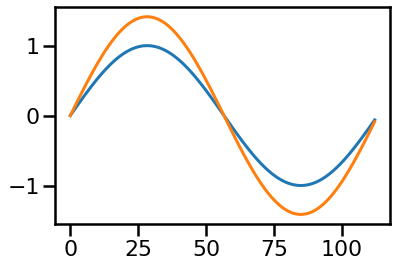

In [157]:
plt.plot(cyc1)
plt.plot(cyc2)

In [39]:
times = create_times(n_seconds, fs)
ap = sim_powerlaw(n_seconds, fs, exponent=-1, f_range=(1.5, 50), variance=0.1) 

In [40]:
is_osc = make_is_oscillating(n_seconds, fs, cf, 3, 7)

In [41]:
bursts = create_bursts(n_seconds, fs, cf, is_osc)

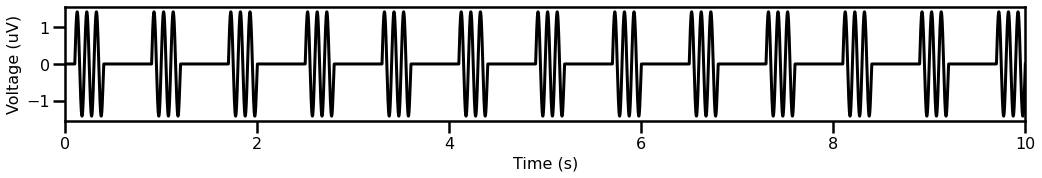

In [42]:
plot_time_series(times, bursts, xlim=[0, 10])

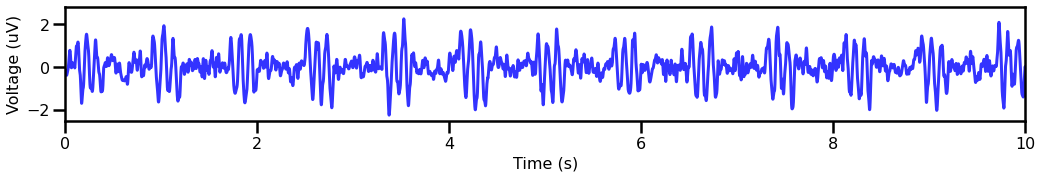

In [43]:
plot_time_series(times, bursts+ap, xlim=[0, 10], colors=c1, alpha=0.8)

In [44]:
b_labels = get_burst_samples(is_osc, fs, cf)

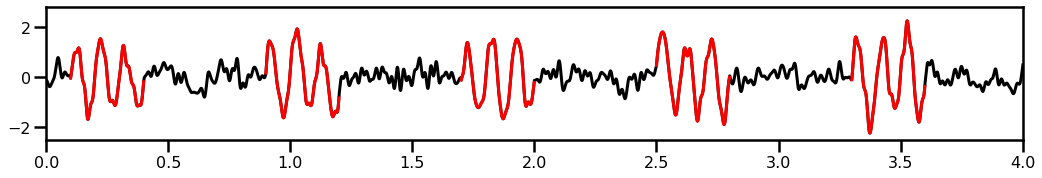

In [45]:
plot_bursts(times, bursts+ap, b_labels, **plt_kwargs, xlim=[0, 4])

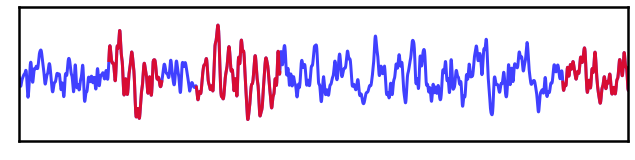

In [46]:
# Plot a segment of burst detection on the first signal
_, ax = plt.subplots(figsize=(10, 3))
plot_bursts(times, sig2, bursting2, **plt_kwargs, xlim=[0, 5],
            colors=[c1, 'red'], alpha=[0.75, 0.8], ax=ax)
plt.xticks([]); plt.yticks([]);

### Short vs Long Bursts

In [47]:
# Make short bursts
is_osc = make_is_oscillating(n_seconds, fs, 10, 3, 7)
bursts = create_bursts(n_seconds, fs, cf, is_osc)
short_bursts = ap + bursts

# Make long bursts
is_osc = make_is_oscillating(n_seconds, fs, 10, 5, 7)
bursts = create_bursts(n_seconds, fs, cf, is_osc)
long_bursts = ap + bursts

In [48]:
plt_clear = {'xlabel': '', 'ylabel': ''}

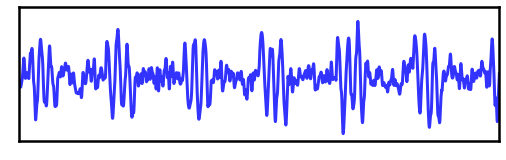

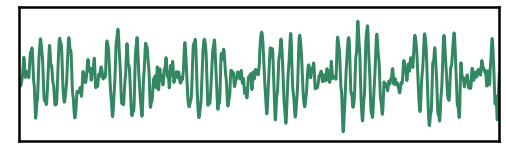

In [49]:
_, ax = plt.subplots(figsize=(8, 3))
plot_time_series(times, short_bursts, xlim=[0, 5], colors=c1, alpha=0.8, **plt_clear, ax=ax)
ax.set_xticks([]); ax.set_yticks([]);
if SAVE_FIG: plt.savefig('figures/04-ts_burst_duration_low.pdf', bbox_inches='tight')

_, ax = plt.subplots(figsize=(8, 3))
plot_time_series(times, long_bursts, xlim=[0, 5], colors=c2, alpha=0.8, **plt_clear, ax=ax)
ax.set_xticks([]); ax.set_yticks([]);
if SAVE_FIG: plt.savefig('figures/04-ts_burst_duration_high.pdf', bbox_inches='tight')

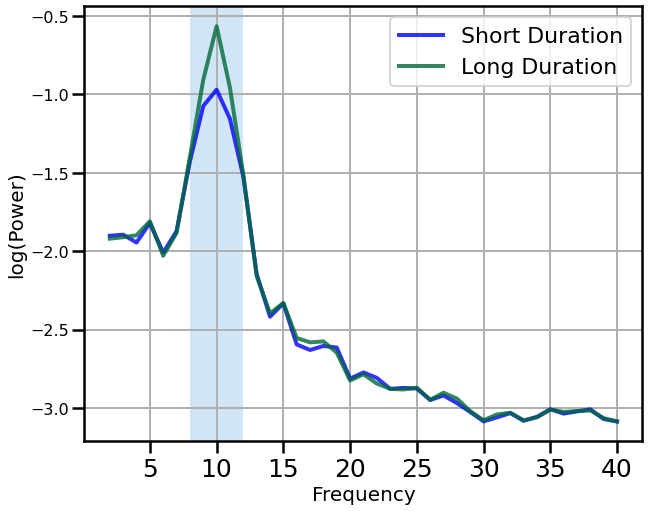

In [50]:
freqs1, powers1 = trim_spectrum(*compute_spectrum(short_bursts, fs, nperseg=nperseg), psd_range)
freqs2, powers2 = trim_spectrum(*compute_spectrum(long_bursts, fs, nperseg=nperseg), psd_range)

plot_spectra_shading(freqs1, [powers1, powers2], [8, 12],
                     labels=['Short Duration', 'Long Duration'],
                     log_freqs=False, log_powers=True,
                     lw=4, shade_colors=alpha_color)

ax = plt.gca()
for line, color in zip(ax.get_lines(), colors):
    line.set_color(color)
    line.set_alpha(0.8)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(25) 

plt.legend(prop={'size': leg_size})
if SAVE_FIG: plt.savefig('figures/04-psd_burst_duration.pdf', bbox_inches='tight')

### Burst Occurence

In [51]:
# Make high occurence bursts
is_osc = make_is_oscillating(n_seconds, fs, 10, 3, 7)
bursts = create_bursts(n_seconds, fs, cf, is_osc)
high_oc_bursts = ap + bursts

# Make low occurence bursts
is_osc = make_is_oscillating(n_seconds, fs, 10, 3, 14)
bursts = create_bursts(n_seconds, fs, cf, is_osc)
low_oc_bursts = ap + bursts

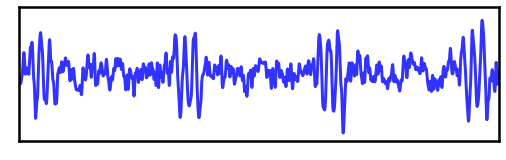

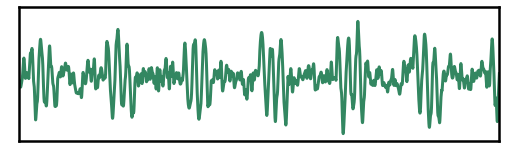

In [52]:
_, ax = plt.subplots(figsize=(8, 3))
plot_time_series(times, low_oc_bursts, xlim=[0, 5], colors=c1, alpha=0.8, **plt_clear, ax=ax)
ax.set_xticks([]); ax.set_yticks([]);
if SAVE_FIG: plt.savefig('figures/04-ts_burst_occurence_low.pdf', bbox_inches='tight')

_, ax = plt.subplots(figsize=(8, 3))
plot_time_series(times, high_oc_bursts, xlim=[0, 5], colors=c2, alpha=0.8, **plt_clear, ax=ax)
ax.set_xticks([]); ax.set_yticks([]);
if SAVE_FIG: plt.savefig('figures/04-ts_burst_occurence_high.pdf', bbox_inches='tight')

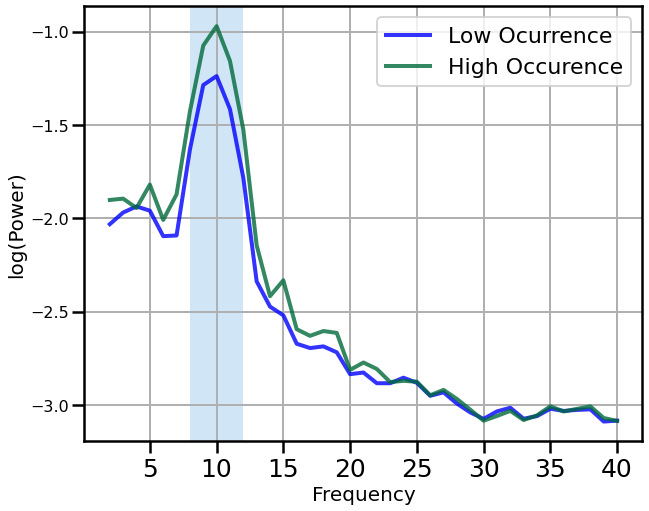

In [53]:
freqs1, powers1 = trim_spectrum(*compute_spectrum(low_oc_bursts, fs, nperseg=nperseg), psd_range)
freqs2, powers2 = trim_spectrum(*compute_spectrum(high_oc_bursts, fs, nperseg=nperseg), psd_range)

plot_spectra_shading(freqs1, [powers1, powers2], [8, 12],
                     labels=['Low Ocurrence', 'High Occurence'],
                     log_freqs=False, log_powers=True,
                     lw=4, shade_colors=alpha_color)

ax = plt.gca()
for line, color in zip(plt.gca().get_lines(), colors):
    line.set_color(color)
    line.set_alpha(0.8)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(25) 

plt.legend(prop={'size': leg_size})
if SAVE_FIG: plt.savefig('figures/04-psd_burst_occurence.pdf', bbox_inches='tight')

### Change Burst Amplitude

In [54]:
# Make low amplitude bursts
is_osc = make_is_oscillating(n_seconds, fs, 10, 3, 7)
bursts = create_bursts(n_seconds, fs, cf, is_osc, variance=1)
low_amp_bursts = ap + bursts

# Make high amplitude bursts
is_osc = make_is_oscillating(n_seconds, fs, 10, 3, 7)
bursts = create_bursts(n_seconds, fs, cf, is_osc, variance=2)
high_amp_bursts = ap + bursts

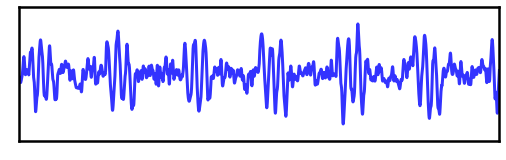

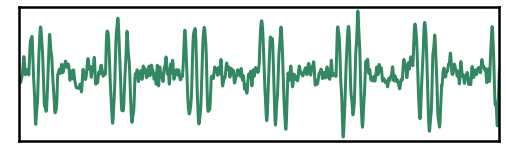

In [55]:
_, ax = plt.subplots(figsize=(8, 3))
plot_time_series(times, low_amp_bursts, xlim=[0, 5], ylim=[-3, 3], colors=c1, alpha=0.8, **plt_clear, ax=ax)
ax.set_xticks([]); ax.set_yticks([]);
if SAVE_FIG: plt.savefig('figures/04-ts_burst_amp_low.pdf', bbox_inches='tight')

_, ax = plt.subplots(figsize=(8, 3))
plot_time_series(times, high_amp_bursts, xlim=[0, 5], ylim=[-3, 3], colors=c2, alpha=0.8, **plt_clear, ax=ax)
ax.set_xticks([]); ax.set_yticks([]);
if SAVE_FIG: plt.savefig('figures/04-ts_burst_amp_high.pdf', bbox_inches='tight')

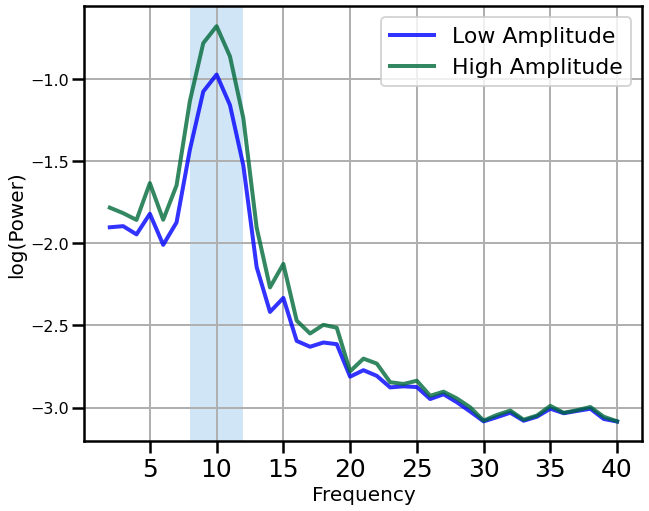

In [56]:
freqs1, powers1 = trim_spectrum(*compute_spectrum(low_amp_bursts, fs, nperseg=nperseg), psd_range)
freqs2, powers2 = trim_spectrum(*compute_spectrum(high_amp_bursts, fs, nperseg=nperseg), psd_range)

plot_spectra_shading(freqs1, [powers1, powers2], [8, 12],
                     labels=['Low Amplitude', 'High Amplitude'],
                     log_freqs=False, log_powers=True,
                     lw=4, shade_colors=alpha_color)

ax = plt.gca()
for line, color in zip(plt.gca().get_lines(), colors):
    line.set_color(color)
    line.set_alpha(0.8)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(25) 

plt.legend(prop={'size': leg_size})
if SAVE_FIG: plt.savefig('figures/04-psd_burst_amplitude.pdf', bbox_inches='tight')

## Spectrograms...

In [57]:
ns = 3
cf = 10
bl = 7

In [58]:
def time_burst(n_seconds, fs, cf, beb, bl):
    
    is_osc = [False] * beb + [True] * bl + [False] * 10
    return create_bursts(n_seconds, fs, cf, is_osc)

In [59]:
bt = time_burst(ns, fs, cf, 10, bl)

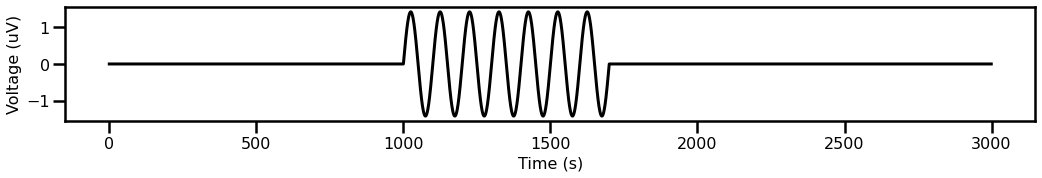

In [60]:
plot_time_series(np.arange(0, len(bt)), bt)

In [61]:
freqs, tt, pxx = spectrogram(bt, fs, window='hann', nperseg=int(0.3*fs))

In [62]:
times = np.arange(-2.5, 0.5, (1/len(times)))

In [63]:
fl = 8

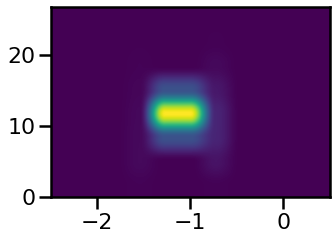

In [64]:
_, ax = plt.subplots(figsize=(5, 3.5))
plt.imshow(pxx[0:fl, :], extent=[times[0], times[-1], freqs[0], freqs[fl]], 
           aspect='auto', origin='lower', interpolation='hanning')

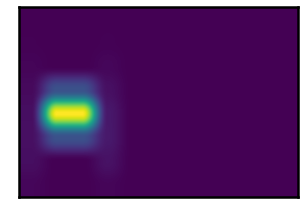

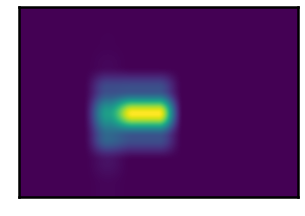

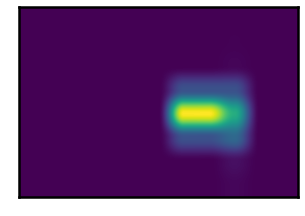

In [65]:
bbs = [2, 9, 16]
for ind, bb in zip(range(len(bbs)), bbs):
    
    bt = time_burst(ns, fs, cf, bb, bl)
    freqs, tt, pxx = spectrogram(bt, fs, window='hann', nperseg=int(0.3*fs))
    
    _, ax = plt.subplots(figsize=(5, 3.5))
    plt.imshow(pxx[0:fl, :], extent=[times[0], times[-1], freqs[0], freqs[fl]], 
           aspect='auto', origin='lower', interpolation='hanning')
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    if SAVE_FIG: plt.savefig('figures/04-indi_spectrogram_' + str(ind) + '.pdf', bbox_inches='tight')

In [66]:
pxxs = []
starts = np.arange(2, 25, 2)
for bs in starts:
    bt = time_burst(ns, fs, cf, bs, bl)
    _, _, pxx = spectrogram(bt, fs, window='hann', nperseg=int(0.3*fs))
    pxxs.append(pxx)

In [67]:
avg_pxx = np.array(pxxs).mean(0)

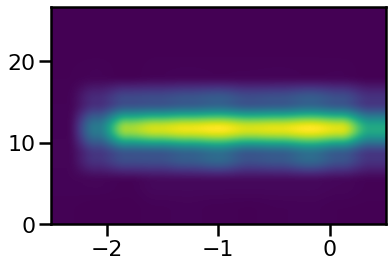

In [68]:
plt.imshow(avg_pxx[0:fl, :], extent=[times[0], times[-1], freqs[0], freqs[fl]], 
           aspect='auto', origin='lower', interpolation='hanning')
if SAVE_FIG: plt.savefig('figures/04-avg_spectrogram.pdf', bbox_inches='tight')

### Conclusions

In the above, we saw that the two simulated signals appeared to have different amounts of alpha power. 

Note that a common interpretation of a change in power is often that the magnitude of the oscillations has changed. 

In this scenario, that would be an inaccurate interpretation. 

As we can see from applying burst detection, the power of the oscillations _when they are present_ is equal. 

This shows how differences in temporal variability can look like power differences. 

Applying burst detection can help address this potential issue. 

As well as being important to check as a control, temporal variability itself may be an interest measure of interest. 